In [ ]:
import math
from PIL import Image, ImageOps
from roboflow import Roboflow

# Load and Preprocess the Mosaic
from PIL import Image

def standardize_background(image, bg_color=(255, 255, 255)):
    if image.mode in ("RGBA", "LA"):
        background = Image.new("RGB", image.size, bg_color)
        background.paste(image, mask=image.split()[-1])
        return background
    else:
        return image.convert("RGB")

mosaic = Image.open("./AL Mosaic 2.16.23.jpg")
mosaic = standardize_background(mosaic)

In [17]:
import numpy as np

def crop_to_content(image, threshold=240):
    # Convert to numpy array
    img_np = np.array(image)
    # Create a mask for non-white pixels (all channels less than threshold)
    mask = (img_np[:,:,0] < threshold) | (img_np[:,:,1] < threshold) | (img_np[:,:,2] < threshold)
    coords = np.argwhere(mask)
    if coords.size == 0:
        return image  # Return original if no content detected
    y0, x0 = coords.min(axis=0)[:2]
    y1, x1 = coords.max(axis=0)[:2] + 1  # add 1 because slice end is exclusive
    return image.crop((x0, y0, x1, y1))

cropped_mosaic = crop_to_content(mosaic)

In [ ]:
# Break the Image into 640x640 Patches
def is_patch_valid(patch, bg_color=(255, 255, 255), tolerance=15, max_fraction=0.9):
    patch_np = np.array(patch)
    # Calculate a boolean mask: True where the pixel is close to the background color.
    close_to_bg = np.all(np.abs(patch_np - bg_color) <= tolerance, axis=-1)
    fraction_bg = np.mean(close_to_bg)
    return fraction_bg < max_fraction

# Example patching:
patch_size = 640
patches = []
valid_patches = []
for y in range(0, cropped_mosaic.height, patch_size):
    for x in range(0, cropped_mosaic.width, patch_size):
        box = (x, y, x + patch_size, y + patch_size)
        patch = cropped_mosaic.crop(box)
        patches.append(patch)
        if is_patch_valid(patch):
            valid_patches.append(patch)

In [20]:
print(f"Total patches: {len(patches)}")
# Show the first 9 patches
for i, patch in enumerate(valid_patches[:9]):
    patch.show()

Total patches: 192


loading Roboflow workspace...
loading Roboflow project...


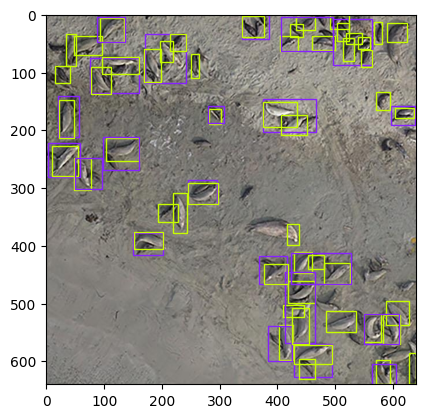

Total clumps detected: 22
Total seals detected: 53


In [15]:
import os
from dotenv import load_dotenv

load_dotenv()
# --- 3. Run Inference on Each Patch with Roboflow ---
# Initialize Roboflow and your model. Replace with your API key, workspace, project, and version.
api_key = os.getenv("ROBOFLOW_API_KEY")
rf = Roboflow(api_key)
project = rf.workspace().project("elephant-seals-project-mark-1")
model = project.version("6").model

total_clumps = 0
total_seals = 0

# for i, patch in enumerate(patches):
for i in range(0, 1):
    # Save the patch temporarily or use an in-memory file if supported by Roboflow.
    # patch_path = f"patches/temp_patch_{i}.jpg"
    patch_path = f"./temp_patch_115.jpg"
    # patch.save(patch_path)
    
    # Run inference. Adjust confidence and overlap parameters as needed.
    result = model.predict(patch_path, confidence=40, overlap=30)

    result.plot()
    
    # Assuming the response JSON has a "predictions" key with a list of detections.
    predictions = result.json().get("predictions", [])

    
    # Count predictions by class.
    clump_count = sum(1 for pred in predictions if pred["class"] == "clump")
    seal_count = sum(1 for pred in predictions if pred["class"] == "seals")
    
    total_clumps += clump_count
    total_seals += seal_count

# --- 4. Output the Results ---
print("Total clumps detected:", total_clumps)
print("Total seals detected:", total_seals)